Plot Antarctic Tidal Currents
=============================

Demonstrates plotting hourly tidal currents around Antarctica

OTIS format tidal solutions provided by Ohio State University and ESR  
- http://volkov.oce.orst.edu/tides/region.html  
- https://www.esr.org/research/polar-tide-models/list-of-polar-tide-models/
- ftp://ftp.esr.org/pub/datasets/tmd/  

Finite Element Solution (FES) provided by AVISO  
- https://www.aviso.altimetry.fr/en/data/products/auxiliary-products/global-tide-fes.html

#### Python Dependencies
 - [numpy: Scientific Computing Tools For Python](https://www.numpy.org)  
 - [scipy: Scientific Tools for Python](https://www.scipy.org/)  
 - [pyproj: Python interface to PROJ library](https://pypi.org/project/pyproj/)  
 - [netCDF4: Python interface to the netCDF C library](https://unidata.github.io/netcdf4-python/)  
 - [matplotlib: Python 2D plotting library](http://matplotlib.org/)  
 - [cartopy: Python package designed for geospatial data processing](https://scitools.org.uk/cartopy/docs/latest/)  

#### Program Dependencies

- `arguments.py`: load the nodal corrections for tidal constituents  
- `astro.py`: computes the basic astronomical mean longitudes  
- `convert_crs.py`: convert points to and from Coordinates Reference Systems  
- `load_constituent.py`: loads parameters for a given tidal constituent  
- `io.model.py`: retrieves tide model parameters for named tide models
- `io.OTIS.py`: extract tidal harmonic constants from OTIS tide models  
- `io.ATLAS.py`: extract tidal harmonic constants from ATLAS netcdf models  
- `io.FES.py`: extract tidal harmonic constants from FES tide models  
- `predict.py`: predict tidal values using harmonic constants  
- `time.py`: utilities for calculating time operations
- `utilities.py`: download and management utilities for files

This notebook uses Jupyter widgets to set parameters for calculating the tidal maps.  

#### Load modules

In [1]:
import os
import pyproj
import datetime
import numpy as np
import matplotlib
matplotlib.rcParams['axes.linewidth'] = 2.0
matplotlib.rcParams["animation.html"] = "jshtml"
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cartopy.crs as ccrs
import ipywidgets as widgets
from IPython.display import HTML

# import tide programs
import pyTMD.io
import pyTMD.time
import pyTMD.predict
import pyTMD.tools
import pyTMD.utilities

# autoreload
%load_ext autoreload
%autoreload 2

#### Set parameters  for program

- Model directory  
- Tide model  
- Date to run  

In [2]:
# available model list
model_list = sorted(pyTMD.io.model.global_current() + pyTMD.io.model.antarctic_current())
# display widgets for setting directory and model
TMDwidgets = pyTMD.tools.widgets()
TMDwidgets.model.options = model_list
TMDwidgets.model.value = 'CATS2008'
widgets.VBox([
    TMDwidgets.directory,
    TMDwidgets.model,
    TMDwidgets.atlas,
    TMDwidgets.compress,
    TMDwidgets.datepick
])

#### Setup tide model parameters

In [84]:
# get model parameters
print(TMDwidgets.model.value)
model = pyTMD.io.model(TMDwidgets.directory.value,
    format=TMDwidgets.atlas.value,
    compressed=TMDwidgets.compress.value
   ).current(TMDwidgets.model.value)

TPXO9-atlas-v5


In [1]:
"""
# https://github.com/tsutterley/pyTMD/blob/main/pyTMD/io/model.py
            # model type
            self.type = ['u','v']
            self.grid_file = self.pathfinder('grid_tpxo9_atlas_30_v5')
            model_files = ['u_q1_tpxo9_atlas_30_v5','u_o1_tpxo9_atlas_30_v5',
                'u_p1_tpxo9_atlas_30_v5','u_k1_tpxo9_atlas_30_v5',
                'u_n2_tpxo9_atlas_30_v5','u_m2_tpxo9_atlas_30_v5',
                'u_s1_tpxo9_atlas_30_v5','u_s2_tpxo9_atlas_30_v5',
                'u_k2_tpxo9_atlas_30_v5','u_m4_tpxo9_atlas_30_v5',
                'u_ms4_tpxo9_atlas_30_v5','u_mn4_tpxo9_atlas_30_v5',
                'u_2n2_tpxo9_atlas_30_v5','u_mf_tpxo9_atlas_30_v5',
                'u_mm_tpxo9_atlas_30_v5']
            self.model_file = dict(u=self.pathfinder(model_files),
                                   v=self.pathfinder(model_files))
            self.projection = '4326'
            self.scale = 1.0/100.0
            self.version = 'v5'
            # model description and references
            self.reference = 'https://www.tpxo.net/global/tpxo9-atlas'                                   
"""

''

#### Setup coordinates for calculating tidal currents

In [91]:
# create an image around Antarctica
xlimits = [-560.*5e3,560.*5e3]
ylimits = [-560.*5e3,560.*5e3]
spacing = [20e3,-20e3]
# x and y coordinates
x = np.arange(xlimits[0],xlimits[1]+spacing[0],spacing[0])
y = np.arange(ylimits[1],ylimits[0]+spacing[1],spacing[1])
xgrid,ygrid = np.meshgrid(x,y)
# x and y dimensions
nx = int((xlimits[1]-xlimits[0])/spacing[0])+1
ny = int((ylimits[0]-ylimits[1])/spacing[1])+1
# convert image coordinates from polar stereographic to latitude/longitude
crs1 = pyproj.CRS.from_epsg(3031)
crs2 = pyproj.CRS.from_epsg(4326)
transformer = pyproj.Transformer.from_crs(crs1, crs2, always_xy=True)
lon,lat = transformer.transform(xgrid.flatten(), ygrid.flatten())

In [92]:
print(nx, ny)
print(x.shape, y.shape)
print(x.shape[0])
print(lon.shape)
print(lat.shape)
print(lon)

281 281
(281,) (281,)
281
(78961,)
(78961,)
[-45.         -44.79463966 -44.58780726 ... 135.41219274 135.20536034
 135.        ]


#### Calculate tide map

In [93]:
# convert from calendar date to days relative to Jan 1, 1992 (48622 MJD)
YMD = TMDwidgets.datepick.value
tide_time = pyTMD.time.convert_calendar_dates(YMD.year, YMD.month,
    YMD.day, hour=np.arange(24))
# delta time (TT - UT1) file
delta_file = pyTMD.utilities.get_data_path(['data','merged_deltat.data'])

# save tide currents
tide = {}
# iterate over u and v currents
print(model.format)
for TYPE in model.type:
    # read tidal constants and interpolate to grid points
    if model.format in ('OTIS','ATLAS','ESR'):
        amp,ph,D,c = pyTMD.io.OTIS.extract_constants(lon, lat, model.grid_file,
            model.model_file['u'], model.projection, type=TYPE,
            method='spline', grid=model.format)
        DELTAT = np.zeros_like(tide_time)
    elif (model.format == 'netcdf'):
        print(TYPE)
        print(model.model_file[TYPE])
        amp,ph,D,c = pyTMD.io.ATLAS.extract_constants(lon, lat, model.grid_file,
            model.model_file[TYPE], type=TYPE, method='spline',
            scale=model.scale, compressed=model.compressed)
        DELTAT = np.zeros_like(tide_time)
    elif (model.format == 'GOT'):
        amp,ph,c = pyTMD.io.GOT.extract_constants(lon, lat, model.model_file[TYPE],
            method='spline', scale=model.scale,
            compressed=model.compressed)
        # interpolate delta times from calendar dates to tide time
        DELTAT = pyTMD.time.interpolate_delta_time(delta_file, tide_time)
    elif (model.format == 'FES'):
        amp,ph = pyTMD.io.FES.extract_constants(lon, lat, model.model_file[TYPE],
            type=TYPE, version=model.version, method='spline',
            scale=model.scale, compressed=model.compressed)
        c = model.constituents
        # interpolate delta times from calendar dates to tide time
        DELTAT = pyTMD.time.interpolate_delta_time(delta_file, tide_time)
        
    # calculate complex phase in radians for Euler's
    cph = -1j*ph*np.pi/180.0
    # calculate constituent oscillation
    hc = amp*np.exp(cph)

    # allocate for tide current map calculated every hour
    tide[TYPE] = np.ma.zeros((ny,nx,24))
    for hour in range(24):
        # predict tidal elevations at time and infer minor corrections
        TIDE = pyTMD.predict.map(tide_time[hour], hc, c, deltat=DELTAT[hour],
            corrections=model.format)
        MINOR = pyTMD.predict.infer_minor(tide_time[hour], hc, c,
            deltat=DELTAT[hour], corrections=model.format)
        # add major and minor components and reform grid
        tide[TYPE][:,:,hour] = np.reshape((TIDE+MINOR),(ny,nx))

netcdf
u
[PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_q1_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_o1_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_p1_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_k1_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_n2_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_m2_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_s1_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_s2_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_k2_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_m4_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_ms4_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioe

/home/bioer/.pyenv/versions/3.11.3/envs/py311/lib/python3.11/site-packages/pyTMD-2.0.6.dev8+gb8f2a2a-py3.11.egg/pyTMD/io/ATLAS.py:333: RuntimeWarning: divide by zero encountered in divide
  ampl.data[:,i] = np.abs(hci.data)/unit_conv


v
[PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_q1_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_o1_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_p1_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_k1_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_n2_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_m2_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_s1_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_s2_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_k2_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_m4_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_ms4_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/pytho

In [22]:
#The following is debugging code
print(tide['u'].shape)
print(tide['u'])
print(tide['v'])

(281, 281, 24)
[[[22.702240779544436 31.920712036123252 34.5345824432757 ...
   -45.929742175002474 -30.871341002818088 -16.472567182508904]
  [21.712403589132073 28.94642938404152 29.841913263308207 ...
   -41.717962757637935 -27.1090705749661 -13.788743559632904]
  [20.614151622096227 25.2373958347111 23.899474909685367 ...
   -36.010655029333655 -22.164322629577303 -10.418879493269792]
  ...
  [-170.2604117054895 -185.66045212730586 -141.34370369535733 ...
   222.5741295015517 90.96033415942055 -46.97522409990617]
  [-179.3809235666258 -194.64242472371734 -147.57359118193713 ...
   229.41691018369747 92.30393329988681 -51.11092194955358]
  [-182.2589653288664 -196.77750955795034 -148.3493944057458 ...
   228.1769747254173 90.11828506018307 -54.07180588220181]]

 [[20.77243760350372 28.649008265739546 30.912916106685167 ...
   -39.53827335298365 -26.03889635541401 -13.76011172699781]
  [21.725775838108497 27.253325274544665 27.295580259750025 ...
   -33.45532474669009 -20.07277408393

In [24]:
print(tide_time.shape)
print(lon.shape)
print(tide_time)
print(lon, lat)

(24,)
(281, 281)
[11537.         11537.04166667 11537.08333333 11537.125
 11537.16666667 11537.20833333 11537.25       11537.29166667
 11537.33333333 11537.375      11537.41666667 11537.45833333
 11537.5        11537.54166667 11537.58333333 11537.625
 11537.66666667 11537.70833333 11537.75       11537.79166667
 11537.83333333 11537.875      11537.91666667 11537.95833333]
[[ -45.          -44.79463966  -44.58780726 ...   44.58780726
    44.79463966   45.        ]
 [ -45.20536034  -45.          -44.79315693 ...   44.79315693
    45.           45.20536034]
 [ -45.41219274  -45.20684307  -45.         ...   45.
    45.20684307   45.41219274]
 ...
 [-134.58780726 -134.79315693 -135.         ...  135.
   134.79315693  134.58780726]
 [-134.79463966 -135.         -135.20684307 ...  135.20684307
   135.          134.79463966]
 [-135.         -135.20536034 -135.41219274 ...  135.41219274
   135.20536034  135.        ]] [[-54.67352879 -54.79194342 -54.91000461 ... -54.91000461 -54.79194342
  -54.6

In [83]:
import numpy as np
# Set the time index (0 to 23)
t = 0

x = lon.reshape(ny, nx)
y = lat.reshape(ny, nx)

# Reshape u and v to 2D
u0 = tide['u'][:,:,t].reshape(ny, nx)
v0 = tide['v'][:,:,t].reshape(ny, nx)

# Calculate magnitude of the current
#scale = 1
#magnitude = np.sqrt(u0**2 + v0**2) * scale
#print(u0)
#print(v0)
#print(magnitude)
# Create a grid of indices for subsetting
# Y, X = np.meshgrid(np.arange(ny), np.arange(nx))

# Subset every nth arrow for cleaner plot
# n = 10
# mask = (X % n == 0) & (Y % n == 0)



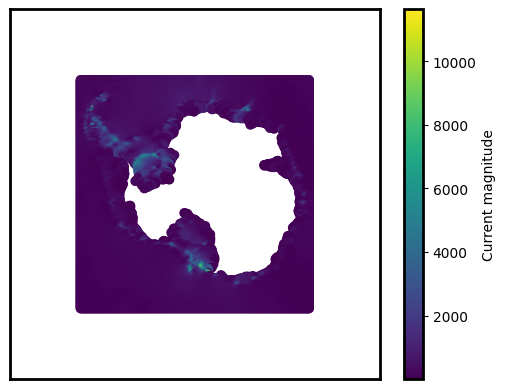

In [26]:
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt

# Create a figure
fig = plt.figure()

# Create a map using the stereographic projection focused on the South Pole
m = Basemap(projection='spstere', boundinglat=-50, lon_0=180, resolution='l')

# Convert lon, lat to map coordinates
x, y = m(lon, lat)
u = tide['u'][:,:,t]
v = tide['v'][:,:,t]
# Compute the magnitudes of the vectors
magnitudes = np.sqrt(np.square(u) + np.square(v))

# Make a scatter plot colored by the magnitudes
sc = m.scatter(x, y, c=magnitudes)

# Add a colorbar
plt.colorbar(sc, label='Current magnitude')

# Show the plot
plt.show()


In [66]:
t = 0

x = lon #.reshape(ny, nx)
y = lat #.reshape(ny, nx)

# Reshape u and v to 2D
u0 = tide['u'][:,:,t] #.reshape(ny, nx)
v0 = tide['v'][:,:,t] #.reshape(ny, nx)

# Create a grid of indices for subsetting
# ny, nx = np.shape(lon)
Y, X = np.meshgrid(np.arange(ny), np.arange(nx))

# Calculate magnitude of the current
#magnitude = np.sqrt(u0**2 + v0**2)

# Normalize the arrows to create a uniform arrow size across the plot
#u = u0/magnitude
#v = v0/magnitude

n = 10
mask = (X % n == 0) & (Y % n == 0)

x = x[mask]
y = y[mask]
u = u0[mask]
v = v0[mask]
#magnitude = magnitude[mask]
#print(x)
#print("----")
print(u0)
print("----")
#print(mag)


[[22.702240779544436 21.712403589132073 20.614151622096227 ...
  -170.2604117054895 -179.3809235666258 -182.2589653288664]
 [20.77243760350372 21.725775838108497 21.62108489310399 ...
  -169.29891691874164 -175.73163953872688 -177.41771466432436]
 [16.694647443125735 18.991458137640144 19.569551634661966 ...
  -165.5116532152816 -170.36723115984745 -171.67491659479032]
 ...
 [-39.23867474722456 -39.440773063007605 -40.675787216958746 ...
  -34.33287743265262 -33.064767779677865 -31.921086045843495]
 [-38.68421500663228 -38.68028035796655 -39.59477450721816 ...
  -36.06930946881846 -34.65834304292016 -33.787793397956044]
 [-41.09360456065472 -38.27312368486945 -37.797072426927905 ...
  -37.90486318135645 -36.81825285582704 -36.32709278354577]]
----


[[1.0 1.0 1.0 ... 1.0 1.0 1.0]
 [1.0 1.0 1.0 ... 1.0 1.0 1.0]
 [1.0 1.0 1.0 ... 1.0 1.0 1.0]
 ...
 [1.0 1.0 1.0 ... 1.0 1.0 1.0]
 [1.0 1.0 1.0 ... 1.0 1.0 1.0]
 [1.0 1.0 1.0 ... 1.0 1.0 1.0]]
[[0.1193194517701502 0.1144222388030909 0.10862784247751772 ...
  -0.9611353401802011 -0.9625529730363308 -0.9638565127158508]
 [0.08410204444989838 0.08726903402482099 0.08762878673905929 ...
  -0.9639768537607183 -0.9669687930741095 -0.9693846854225945]
 [0.037108366353887784 0.04879936706305691 0.05474037587556884 ...
  -0.967138336437761 -0.9679305908969449 -0.9693593236839163]
 ...
 [-0.6828345977365683 -0.7082259932902035 -0.7196142047295085 ...
  -0.9960458889804729 -0.9997611179334804 -0.9967686057506887]
 [-0.5548016020392468 -0.5691808428257012 -0.5911012281197457 ...
  -0.9682233956063683 -0.9797542697035491 -0.9819200335236985]
 [-0.4707575957950388 -0.4768968069794573 -0.48845223924052666 ...
  -0.994590526273172 -0.9921468493112805 -0.9837473099809553]]
[[1.0 1.0 1.0 ... 1.0 1.0 1.0]

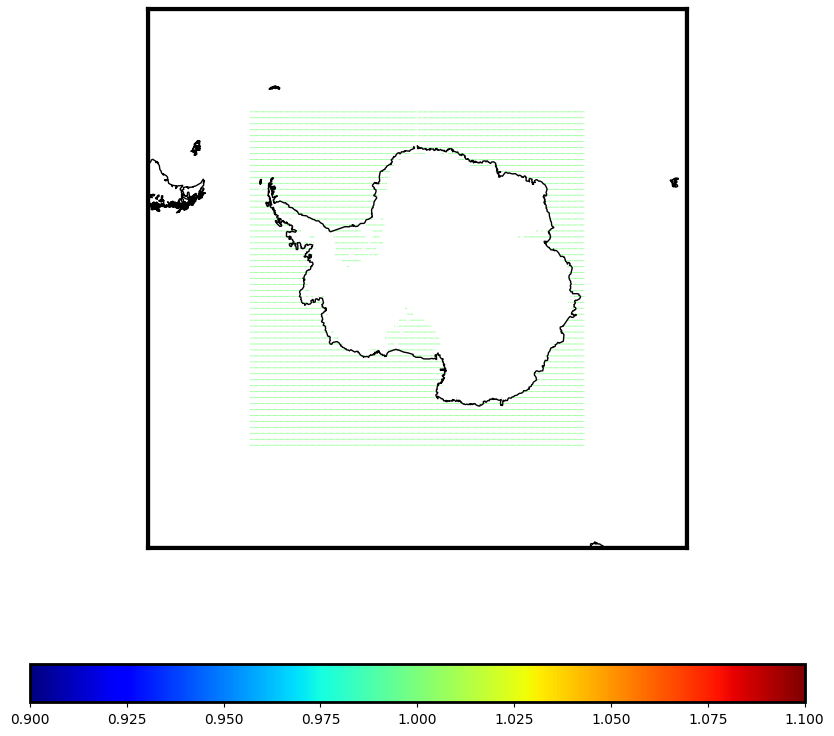

In [80]:
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt

# Create a figure
fig = plt.figure(figsize=(10, 10))

# Create a map using the stereographic projection focused on the South Pole
m = Basemap(projection='spstere', boundinglat=-50, lon_0=180, resolution='l')

x, y = m(lon, lat)
# If necessary, you might need to reshape u and v to match the shapes of lon and lat

# Draw coastlines.
m.drawcoastlines()

# Draw a thick border around the whole map.
m.drawmapboundary(linewidth=3)

u = u0 # reshape(lon.shape)
v = v0 #.reshape(lat.shape)

# Calculate the magnitude and normalize u, v by the magnitude
magnitude = np.sqrt(u**2 + v**2)
print(magnitude)
u /= magnitude
v /= magnitude

# Subsample the data to avoid having arrows that are too close to each other
# Here we're taking every 10th data point (change this if it's too much or too little for your data)
subsample = 5
x = x[::subsample]
y = y[::subsample]
u = u[::subsample]
v = v[::subsample]
magnitude = magnitude[::subsample]
print(u)
print(magnitude)
# Make a quiver plot
quiv = m.quiver(x, y, u, v, magnitude, 
                angles='xy', scale_units='xy', 
                scale=1, pivot='middle', width=0.002, cmap='jet')

# Add a colorbar
plt.colorbar(quiv, orientation='horizontal')

# Show the plot
plt.show()

In [23]:
# the following is just used for debugging
#with open('debug_lon.log', 'w') as f:
#    f.write(np.array2string(lon, threshold=np.inf))

#with open('debug_lat.log', 'w') as f:
#    f.write(np.array2string(lat, threshold=np.inf))

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Set the time index (0 to 23)
t = 0

lon = lon.reshape(ny, nx)
lat = lat.reshape(ny, nx)

# Reshape u and v to 2D
u = tide['u'][:,:,t].reshape(ny, nx)
v = tide['v'][:,:,t].reshape(ny, nx)

# Create a grid of indices for subsetting
# ny, nx = np.shape(lon)
Y, X = np.meshgrid(np.arange(ny), np.arange(nx))

# Calculate magnitude of the current
magnitude = np.sqrt(u**2 + v**2)

# Normalize the arrows to create a uniform arrow size across the plot
u = u/magnitude
v = v/magnitude

print(magnitude)
print(u)
print(v)
# Subset every nth arrow for cleaner plot
n = 10
mask = (X[::n, ::n], Y[::n, ::n])
print(mask)

print("debug is nan in u, v")
print(np.isnan(u).any())
print(np.isnan(v).any())
print("debug is max, min in u, v")
print(np.max(u), np.min(u), np.max(v), np.min(v))

with open('debug.log', 'w') as f:
    f.write(np.array2string(lon[mask], threshold=np.inf))
    f.write(np.array2string(lat[mask], threshold=np.inf))
    f.write(np.array2string(magnitude, threshold=np.inf))  

[[190.26437385311377 189.75684985937852 189.76858190258778 ...
  177.14509558411177 186.3595340636439 189.0934624857353]
 [197.11546435633957 197.00514562987422 195.86076460514667 ...
  176.18127701813953 182.64611172575079 184.05471422265174]
 [205.82541118677727 203.66806712114294 199.7037876454192 ...
  172.30779640343346 176.9539750394958 177.80545300686023]
 ...
 [82.01803115927532 78.29412791350158 76.57025810064647 ...
  34.7542749387278 34.0192344794682 33.294487823078335]
 [83.63325535923408 79.56692683971424 77.6044590289076 ...
  36.35905205578413 35.17844850189233 34.7537580357261]
 [87.29249390284144 80.25451863953892 77.38130648289574 ...
  38.111023763105486 37.10968077093144 36.927260095124474]]
[[0.1193194517701502 0.1144222388030909 0.10862784247751772 ...
  -0.9611353401802011 -0.9625529730363308 -0.9638565127158508]
 [0.10538207984509991 0.11028024556742319 0.1103900770360612 ...
  -0.9609359165974868 -0.9621427901109321 -0.9639400730029736]
 [0.08111072071648187 0.

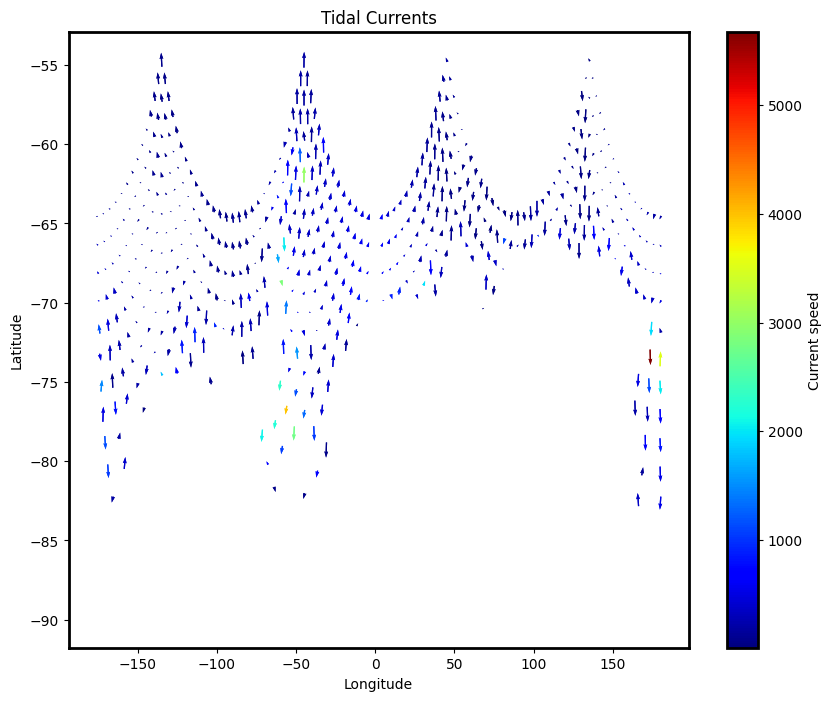

In [31]:
# This plot will fail for Antarctic currents because it create a polar stereographic grid of points
# and then converting those points into a latitude/longitude grid. 
# A polar stereographic projection maps points from a sphere to a plane by projecting those points 
# from the sphere's surface to the plane from a reference point (e.g., the North or South Pole). 
# The nature of this projection results in distortion as you move away from the reference point.

# Calculate magnitude of the current
# Create a figure and plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plotting, note the "angles" and "scale" parameters
ax.quiver(lon[mask], lat[mask], u[mask], v[mask], magnitude[mask], 
          angles='xy', scale_units='xy', scale=1, pivot='middle', 
          width=0.002, cmap='jet')

#ax.quiver(lon, lat, u, v, magnitude, 
#          angles='xy', scale_units='xy', scale=1, pivot='middle', 
#          width=0.002, cmap='jet')

ax.set_title('Tidal Currents')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.colorbar(ax.quiver(lon[mask], lat[mask], u[mask], v[mask], 
                       magnitude[mask], angles='xy', scale_units='xy', 
                       scale=1, pivot='middle', width=0.002, cmap='jet'), 
             ax=ax, label='Current speed')

plt.show()

In [ ]:
#pip uninstall cartopy
#pip uninstall shapely
#pip install --no-binary :all: shapely
#pip install cartopy

In [ ]:
#The following code crash kernel

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create a figure and plot using Cartopy
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.SouthPolarStereo()},
                       figsize=(10, 8))

# Set up the map: limit extent, add coastlines and a grid
ax.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.gridlines()

# Use quiver to plot vectors, but now in transformed coordinates
Q = ax.quiver(lon[mask], lat[mask], u[mask], v[mask], current_magnitude[mask], 
              transform=ccrs.PlateCarree(), scale=1, pivot='middle', width=0.0015, cmap='jet')

# Add a colorbar based on the quiver plot
plt.colorbar(Q, ax=ax, label='Current speed', orientation='horizontal')

ax.set_title('Tidal Currents')
plt.show()

#### Create animation of hourly tidal oscillation

In [7]:
# output Antarctic Tidal Current Animation
projection = ccrs.Stereographic(central_longitude=0.0,
    central_latitude=-90.0,true_scale_latitude=-71.0)
# figure axis and image objects
ax1,im = ({},{})
fig, (ax1['u'],ax1['v']) = plt.subplots(num=1, ncols=2,
    figsize=(11.5,7), subplot_kw=dict(projection=projection))
vmin = np.min([tide['u'].min(),tide['v'].min()])
vmax = np.max([tide['u'].max(),tide['v'].max()])
extent = (xlimits[0],xlimits[1],ylimits[0],ylimits[1])
for TYPE,ax in ax1.items():
    # plot tidal currents
    im[TYPE] = ax.imshow(np.zeros((ny,nx)),
        interpolation='nearest', vmin=vmin, vmax=vmax,
        transform=projection, extent=extent, origin='upper',
        animated=True)
    # add high resolution cartopy coastlines
    ax.coastlines('10m')
    # set x and y limits
    ax.set_xlim(xlimits)
    ax.set_ylim(ylimits)
    # stronger linewidth on frame
    ax.spines['geo'].set_linewidth(2.0)
    ax.spines['geo'].set_capstyle('projecting')

# Add colorbar with a colorbar axis
# Add an axes at position rect [left, bottom, width, height]
cbar_ax = fig.add_axes([0.085, 0.075, 0.83, 0.035])
# extend = add extension triangles to upper and lower bounds
# options: neither, both, min, max
cbar = fig.colorbar(im['u'], cax=cbar_ax, extend='both',
    extendfrac=0.0375, drawedges=False, orientation='horizontal')
# rasterized colorbar to remove lines
cbar.solids.set_rasterized(True)
# Add label to the colorbar
cbar.ax.set_title(f'{model.name} Tidal Velocity', fontsize=13,
    rotation=0, y=-1.65, va='top')
cbar.ax.set_xlabel('cm/s', fontsize=13, rotation=0, va='center')
cbar.ax.xaxis.set_label_coords(1.075, 0.5)
# ticks lines all the way across
cbar.ax.tick_params(which='both', width=1, length=18,
    labelsize=13, direction='in')

# add title (date and time)
ttl = fig.suptitle(None, y=0.97, fontsize=13)
# adjust subplot within figure
fig.subplots_adjust(left=0.02,right=0.98,bottom=0.1,top=0.98,wspace=0.04)
           
# animate each map
def animate_maps(hour):
    # set map data iterating over u and v currents
    for TYPE in model.type:
        im[TYPE].set_data(tide[TYPE][:,:,hour])
    # set title
    args = (YMD.year,YMD.month,YMD.day,hour)
    ttl.set_text('{0:4d}-{1:02d}-{2:02d}T{3:02d}:00:00'.format(*args))

# set animation
anim = animation.FuncAnimation(fig, animate_maps, frames=24)
%matplotlib inline
HTML(anim.to_jshtml())

: 

: 